In [ ]:
# Modules

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import csv
from data_analysis_baseline import *


# Files 
x_train_csv = "dataset/x_train.csv"
y_train_csv = "dataset/y_train.csv"




# 1. Exploratory Data Anslysis

## 1.1 Data Preprocessing for Analysis

1.  Read CSV files and convert into array format.
     - Will maintain features (column names) as separate list and map column name to its data by indexing list.



**1.1.1 Functions for data preprocessing**

In [3]:
# ------------------- Functions for data preprocessing ------------------------------ #


def csv_to_array(csv_file):
    '''
    Read csv file and store content into array structure
    '''
    data = []
    with open(csv_file,  newline='') as file_csv:
        csvreader = csv.reader(file_csv, delimiter=',')
        # First extract column names from data
        column_names = next(csvreader)
        for row in csvreader:
            # Append blanck values as NaN (before leading with them)
            # Do not include first column as it serves as identifier
            data.append([float(val) if val != '' else float('nan') for val in row[1:]])
        
        # Transfrom nested list into 2D array
        data = np.array(data)
            
        # For column names dont return ID feature
        column_names = column_names[1:]


    return data, column_names

In [4]:
# Read x_train and y_train
x_train, features = csv_to_array("dataset/x_train.csv")
y_train, labels = csv_to_array("dataset/y_train.csv")
# Flatten y_train to convert into 1d array
y_train = y_train.flatten()



**1.1.2 Checking results from data preprocessing**

In [5]:
# Features and labels
print(f'A sample of features: {features[:10]}')
print(f'Labels: {labels}')

# First rows of dataset
print(f'x_train sample: {x_train[:2,:5]}')
print(f'y_train sample: {y_train[:2]}')

A sample of features: ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU', 'CTELENUM']
Labels: ['_MICHD']
x_train sample: [[5.3000000e+01 1.1000000e+01 1.1162015e+07 1.1000000e+01 1.6000000e+01]
 [3.3000000e+01 1.2000000e+01 1.2152015e+07 1.2000000e+01 1.5000000e+01]]
y_train sample: [-1. -1.]


## 1.2 Data Analysis for Training
Analyze data for training: design strategies for training based on data structure (e.g., missing values).

**1.2.1 Dimensions of datasets**

In [6]:
N_samples = y_train.shape[0]
N_features = x_train.shape[1]
print(f'Number of samples:  {N_samples}')
print(f'Number of features:  {N_features}')

Number of samples:  328135
Number of features:  321


**1.2.2. Checking for data imbalances in labels distribution**

- y: Patient has suffered myocardial Infarct or Coronary Heart Disease (MICHD) 
     - -1 -> No
     - 1 -> Yes


**Plotting distribution of label distribution**

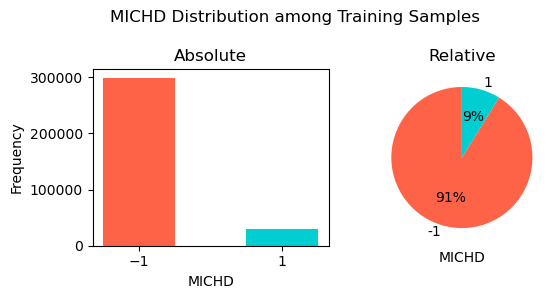

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (6,3))
plt.suptitle('MICHD Distribution among Training Samples')

# Bar plot
# Separate the -1 and 1 values into two arrays for plotting with different colors
y_train_neg = y_train[y_train == -1]
y_train_pos = y_train[y_train == 1]
ax1.hist(y_train_neg, bins=3, range=(-1.5, 1.5), color='tomato')
ax1.hist(y_train_pos, bins=3, range=(-1.5, 1.5), color='darkturquoise')
ax1.set_xticks([-1,1])
ax1.set_xlabel('MICHD')
ax1.set_ylabel('Frequency')
ax1.set_title('Absolute')

# Pie plot
# Return total count for each label
_ , counts = np.unique(y_train, return_counts=True)
labels = ['-1','1']
ax2.pie(counts,labels=labels, autopct='%1.0f%%', startangle=90, colors=['tomato', 'darkturquoise'])
ax2.set_xlabel('MICHD')
ax2.set_title('Relative')

plt.tight_layout()
plt.show()

- Clearly imbalanced data. Perhaps it will be necessary to apply certain strategies to mitifate uneven distribution of levels:
    - Resampling: Use oversampling  or undersampling to balance your data.
    - Class Weights: Adjust the weights in your model to handle the imbalance.
    - Adjust threshold of logistic regression

**1.2.3 Missing data**

**i. Missing data statistics**


Number of samples with at least one NaN: 328135 out of 328135
Number of features with at least one NaN: 239 out of 321


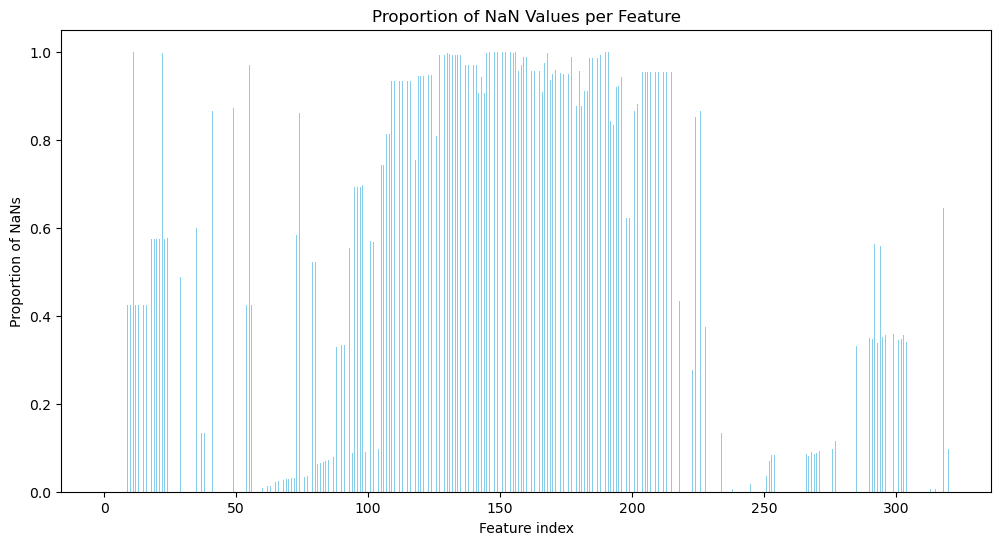

69% of columns have at least 1% missing values
57% of columns have at least 10% missing values
55% of columns have at least 25% missing values
46% of columns have at least 50% missing values
36% of columns have at least 75% missing values
31% of columns have at least 90% missing values


In [8]:
# i. Number of samples with at least one missing value
samples_with_nan = np.sum(np.any(np.isnan(x_train), axis=1))


print(f"Number of samples with at least one NaN: {samples_with_nan} out of {N_samples}")

# ii. Cols with missing values
feautures_with_nan = np.sum(np.any(np.isnan(x_train), axis=0) )
print(f"Number of features with at least one NaN: {feautures_with_nan} out of {N_features}")

nans_per_feature = np.sum(np.isnan(x_train), axis=0)  # Count NaNs in each column
proportion_of_nans = nans_per_feature / N_samples  # Proportion of NaNs in each column

# Plot distribution of missing values per feature
plt.figure(figsize=(12, 6))
plt.bar(range(0,N_features), proportion_of_nans, color='skyblue', width=0.3)
plt.title("Proportion of NaN Values per Feature")
plt.xlabel("Feature index")
plt.ylabel("Proportion of NaNs")
plt.show()

# Missing feature proportion thresholds
proportion_thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9] 

# Calculate how many features have a proportion of NaNs greater than threshold
stats = {}

for threshold in proportion_thresholds:
    cols_with_nans_above_threshold = np.sum(proportion_of_nans >= threshold)
    proportion_of_cols = cols_with_nans_above_threshold / len(proportion_of_nans) * 100
    stats[threshold] = proportion_of_cols
    
for threshold, proportion in stats.items():
    print(f"{proportion:.0f}% of columns have at least {threshold * 100:.0f}% missing values")


In [9]:
threshold = 0.75
high_missing_cols = np.sum(proportion_of_nans > threshold)
print(f"Number of columns with more than {threshold*100:.0f}% missing values: {high_missing_cols}")

Number of columns with more than 75% missing values: 117


**Conclusions**

- All samples have at least one missing value.
- Most columns (74.5%) have at least one missing value.
- **Approach**: not include features given a threshold for proportion of missing values
   - Initially, set threshold to 75% of missing values -> 36% of total columns (117 columns)


### Feature selection analysis

**Manual feature selection**

- **1. Blood Pressure**
    - `BPHIGH4`: Ever told you have high blood pressure.  
        - Values: Yes = 1,2 Yes, but female told only during pregnancy=2, No = 3, Told borderline = 4, Don't know/Refused = 7/9.
    - `BPMEDS`: Currently taking blood pressure medication.  
        - Values: Yes = 1, No = 2, Don’t know/Refused = 7/9.

- **2. Cholesterol**
    - `TOLDHI2`: Ever told your cholesterol is high.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.

- - **3. Sleep Patterns**
    - `ADSLEEP`: Trouble falling or staying asleep, or sleeping too much in the last 2 weeks?  
        - Values: Numeric (days)., 1 - 14  days; 88/77/99



- **4. Diabetes**
    - `DIABETE3`: Ever told you have diabetes.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `DIABAGE2`: Age when diagnosed with diabetes.  
        - Values: Numeric (age in years); 1-97; 98: not sure, 99=refused
    - `PDIABTST`: Have you had a test for high blood sugar or diabetes within the past three years?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.

- **5. Lifestyle Factors**
    - `SMOKE100`: Smoked at least 100 cigarettes in your life.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `SMOKDAY2`: Frequency of days currently smoking.  
        - Values: 1= every day; 2=some day; 3= not at all; 7/9: dont know/refused
    - `ALCDAY5` (two cols): Days in past 30 days with alcoholic beverage consumption.  
        - Values: Numeric (days).1(01) - 1(99) Days per week; 2(01) - 2(99) Days in past 30 days, 888: no drink, 777/999: dont know/refused
    - `AVEDRNK2`: Average number of drinks per day when drinking.  
        - Values: Numeric (number of drinks): 1-76; 77/99

- **6. Body Mass Index (BMI)**
    - `WEIGHT2`(Column: 178-181): Reported weight (numeric, pounds): 50 - (0)999 (pounds), (9)000 - (9)998 (kg) , 7777/9999 
    - `HEIGHT3`(182-185): Reported height (numeric, inches). 200 - 711 Height (ft/inches),  0 _ / _ _ = feet / inches, (9)000 - (9)998 Height (meters/centimeters), 7777/9999
    - **BMI**: Computed from weight and height.

- **7. Physical Health**
    - `PHYSHLTH`: Days in past 30 days when physical health was not good.  
        - Values: Numeric (days)., 1-30, 88: none, 77/99
    - `POORHLTH`: Days in past 30 days when physical or mental health kept you from usual activities.  (same)
        - Values: Numeric (days).
    - `ADENERGY`: Over the last 2 weeks, how many days have you felt tired or had little energy?  
        - Values: Numeric (days).01-14 days ; 88= none; 77/99

- **8. Health Care Access**
    - `HLTHPLN1`: Do you have health care coverage?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `CHECKUP1`: Time since last routine checkup.  
        - Values: Within past year = 1, 1-2 years = 2, 2-5 years = 3, 5+ years = 4, Never = 8, Don't know/Refused = 7/9.

- **9. Physical Activity**
    - `QLACTLM2`: Activity limitation due to health problems.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `EXERANY2`: Participated in physical activities outside of work in the past 30 days?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `STRENGTH`(244-246): Frequency of strength training in the past month.  
        - Values: Numeric (times per week/month), 101 - 199 Times per week, 201 - 299 Times per month, 888: never, 777/999
    - `EXEROFT1` (230-232): Frequency of physical activity in the past month.  How Many Times Walking, Running, Jogging, or Swimming
        - Values: Numeric (times per week/month). (same above, without 888)

- **10. Stress and Mental Health**
    - `MENTHLTH`: Days in past 30 days when mental health was not good.  
        - Values: Numeric (days). 1 - 30 Number of days; 88,77,99
    - `ADANXEV`: Ever told you have anxiety disorder?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `CIMEMLOS`: Experienced confusion or memory loss in the past year?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `ADDEPEV2`: Ever told you have a depressive disorder?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.

- **11. Diet**
    - `FRUTDA1_`: Frequency of fruit consumption per day.  0 - 9999 Times per day
    - `BEANDAY_`: Frequency of beans or lentils consumption per day.
    - `GRENDAY_`: Frequency of dark greens consumption per day.
    - `ORNGDAY_`: Frequency of orange-colored vegetables perday
    - `VEGEDA1_`: Frequency of other vegetables per week.
    - `DRADVISE`: Doctor advised to reduce sodium or salt intake.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.

- **12. Comorbidities**
    - `CVDSTRK3`: Ever diagnosed with stroke?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `HAVARTH3`: Ever diagnosed with arthritis?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `CHCCOPD1`: Ever diagnosed with COPD?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `JOINPAIN`: Severity of joint pain in the past 30 days.  
        - Values: Numeric (scale). 0 - 10 Enter number, 77/99
    - `ASPUNSAF`: Is taking aspirin unsafe due to a health condition?  
        - Values: Yes, not stomach related = 1, Yes, stomach related = 2, No =3,  Don't know/Refused = 7/9.
    - `ASTHMA3`: Ever diagnosed with asthma?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `ASTHMAGE`: How old were you when you were first told by a doctor, nurse or other health professional that you had asthma?
        - Values: 11 - 96 Age 11 or older, 97: 10 or younger, 98: dont know; 99: refused

- **13. Age, Gender and Race**
   
    - `_AGEG5YR`: (Five-Year Age Categories)

        - Numeric:  1-13; 14: Not known/missing
        - Also for age:  - `AGE`: Respondent's age (numeric): 18-90, 7/9, `_AGE65YR`: 2 LEVEL age category; 18-64:1 ; > 65; 7/9 (also 14 group)
    - `SEX`: Respondent's gender (male = 1, female = 2).
    - `_RACEGR3`: 
    
            - Values: categorical: 1 = White only (Non-Hispanic), 2 = Black only (Non-Hispanic) ,   3  = Other race only (Non-Hispanic), 4 = Multiracial (Non-Hispanic), 5 = Hispanic , 
            9= Don’t know/Not sure/Refused
             - Likely to be the most useful for studying myocardial infarction risk. It combines a small number of categories, differentiates Hispanic origin, and includes distinctions for White, Black, multiracial, and other races.




In [10]:
target_features = [
    "BPHIGH4", "BPMEDS", "TOLDHI2", "DIABETE3", "DIABAGE2", "PDIABTST",
    "SMOKE100", "SMOKDAY2", "ALCDAY5", "AVEDRNK2", "WEIGHT2", "HEIGHT3", "PHYSHLTH",
    "POORHLTH", "ADENERGY", "HLTHPLN1", "CHECKUP1", "QLACTLM2", "EXERANY2", "STRENGTH", 
    "EXEROFT1", "MENTHLTH", "ADANXEV", "CIMEMLOS", "ADDEPEV2", "FRUTDA1_",
     "BEANDAY_","GRENDAY_", "ORNGDAY_","VEGEDA1_", "DRADVISE", "CVDSTRK3", "HAVARTH3", 
    "CHCCOPD1", "JOINPAIN", "ASPUNSAF", "ASTHMA3", "ASTHMAGE", 
    "SEX", "ADSLEEP", "_AGEG5YR","_RACEGR3"
]


In [11]:
#  Check all features are present in available features

for feature in target_features:
    try:
        idx = features.index(feature)  # Find the index of each target feature 
    except ValueError:
        print(f"Feature '{feature}' is not in the list of features, possible exclusion or error.")

**Missing value analysis based on NaNs**

In [12]:
# Ensure indexes align directly with target_features
indexes_target_features = [features.index(feature) for feature in target_features if feature in features]

# Count NaNs in each target column and calculate proportions
nans_per_target_feature = np.sum(np.isnan(x_train[:, indexes_target_features]), axis=0)
N_samples = x_train.shape[0]
proportion_of_nans_per_target = nans_per_target_feature / N_samples  # Proportion per column


for i, feature in enumerate(target_features):
    if feature in features:
        index = features.index(feature)  # index in features
        proportion = proportion_of_nans_per_target[i]  # proportion for each feature
        print(f"Feature '{feature}' (Column {index}): {proportion:.2%}")
    else:
        print(f"Feature '{feature}' is missing from the dataset.")

Feature 'BPHIGH4' (Column 34): 0.00%
Feature 'BPMEDS' (Column 35): 59.83%
Feature 'TOLDHI2' (Column 38): 13.35%
Feature 'DIABETE3' (Column 48): 0.00%
Feature 'DIABAGE2' (Column 49): 87.13%
Feature 'PDIABTST' (Column 107): 81.27%
Feature 'SMOKE100' (Column 72): 3.21%
Feature 'SMOKDAY2' (Column 73): 58.32%
Feature 'ALCDAY5' (Column 77): 3.59%
Feature 'AVEDRNK2' (Column 78): 52.08%
Feature 'WEIGHT2' (Column 62): 1.20%
Feature 'HEIGHT3' (Column 63): 1.34%
Feature 'PHYSHLTH' (Column 27): 0.00%
Feature 'POORHLTH' (Column 29): 48.72%
Feature 'ADENERGY' (Column 209): 95.39%
Feature 'HLTHPLN1' (Column 30): 0.00%
Feature 'CHECKUP1' (Column 33): 0.00%
Feature 'QLACTLM2' (Column 65): 2.11%
Feature 'EXERANY2' (Column 87): 7.99%
Feature 'STRENGTH' (Column 94): 8.73%
Feature 'EXEROFT1' (Column 89): 33.26%
Feature 'MENTHLTH' (Column 28): 0.00%
Feature 'ADANXEV' (Column 215): 95.41%
Feature 'CIMEMLOS' (Column 136): 73.60%
Feature 'ADDEPEV2' (Column 46): 0.00%
Feature 'FRUTDA1_' (Column 267): 8.21%
Feat

- Checked for `DIABAGE2`, `SEX`, `DIABETES3` (same proportion as indicated in dataset)

In [92]:
# Define threshold for missing values
threshold = 0.7

# Ensure that indexes match correctly by creating a dictionary of proportions keyed by feature names
proportion_dict = dict(zip(target_features, proportion_of_nans_per_target))

# Filter out features based on the threshold
filtered_features = [feature for feature, proportion in proportion_dict.items() if proportion <= threshold]
eliminated_features =  [feature for feature, proportion in proportion_dict.items() if proportion > threshold]

print("Features with missing value proportion below the threshold:")
print(filtered_features)
print("Features with missing value proportion above the threshold:")
print(eliminated_features)

Features with missing value proportion below the threshold:
['BPHIGH4', 'BPMEDS', 'TOLDHI2', 'DIABETE3', 'SMOKE100', 'SMOKDAY2', 'ALCDAY5', 'AVEDRNK2', 'WEIGHT2', 'HEIGHT3', 'PHYSHLTH', 'POORHLTH', 'HLTHPLN1', 'CHECKUP1', 'QLACTLM2', 'EXERANY2', 'STRENGTH', 'EXEROFT1', 'MENTHLTH', 'ADDEPEV2', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'JOINPAIN', 'ASTHMA3', 'SEX', '_AGEG5YR', '_RACEGR3']
Features with missing value proportion above the threshold:
['DIABAGE2', 'PDIABTST', 'ADENERGY', 'ADANXEV', 'CIMEMLOS', 'DRADVISE', 'ASPUNSAF', 'ASTHMAGE', 'ADSLEEP']


In [14]:
# Define threshold for missing values
threshold = 0.1

# Ensure that indexes match correctly by creating a dictionary of proportions keyed by feature names
proportion_dict = dict(zip(target_features, proportion_of_nans_per_target))

# Filter out features based on the threshold
filtered_features = [feature for feature, proportion in proportion_dict.items() if proportion <= threshold]
eliminated_features =  [feature for feature, proportion in proportion_dict.items() if proportion > threshold]

print("Features with missing value proportion below the threshold:")
print(filtered_features)
print("Features with missing value proportion above the threshold:")
print(eliminated_features)

Features with missing value proportion below the threshold:
['BPHIGH4', 'DIABETE3', 'SMOKE100', 'ALCDAY5', 'WEIGHT2', 'HEIGHT3', 'PHYSHLTH', 'HLTHPLN1', 'CHECKUP1', 'QLACTLM2', 'EXERANY2', 'STRENGTH', 'MENTHLTH', 'ADDEPEV2', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'ASTHMA3', 'SEX', '_AGEG5YR', '_RACEGR3']
Features with missing value proportion above the threshold:
['BPMEDS', 'TOLDHI2', 'DIABAGE2', 'PDIABTST', 'SMOKDAY2', 'AVEDRNK2', 'POORHLTH', 'ADENERGY', 'EXEROFT1', 'ADANXEV', 'CIMEMLOS', 'DRADVISE', 'JOINPAIN', 'ASPUNSAF', 'ASTHMAGE', 'ADSLEEP']


**Range of values for each category (<0.7 missing values)**

- **Binary** (Yes=1, No=2, Don't know/refuse=7,9)
        - `BPMEDS`, `TOLDHI2` , `DIABETE3`, `HLTHPLN1`, `QLACTLM2`, `EXERANY2`, `ADDEPEV2`, `ASTHMA3`, `SMOKE100`,
        `CVDSTRK3`, `HAVARTH3`, `CHCCOPD1`, `SEX`

    
    `BPHIGH4`:- Values: Yes = 1,2 Yes, but female told only during pregnancy=2, No = 3, Told borderline = 4, Don't know/Refused = 7/9.


   
    `_RACEGR3`: 

    - Values: categorical: 1 = White only (Non-Hispanic), 2 = Black only (Non-Hispanic) ,   3  = Other race only (Non-Hispanic), 4 = Multiracial (Non-Hispanic), 5 = Hispanic , 
     9= Don’t know/Not sure/Refused


- **Numeric**
    
    - `SMOKDAY2`:  Values: 1= every day; 2=some day; 3= not at all; 7/9: dont know/refused
    - `ALCDAY5`: 1(01) - 1(99) Days per week; 2(01) - 2(99) Days in past 30 days, 888: no drink, 777/999: dont know/refused
    - `AVEDRNK2`: 1-76; 77/99
    - `WEIGHT2`(Column: 178-181): Reported weight (numeric, pounds): 50 - (0)999 (pounds), (9)000 - (9)998 (kg) , 7777/9999 
    - `HEIGHT3`(182-185): Reported height (numeric, inches). 200 - 711 Height (ft/inches),  0 _ / _ _ = feet / inches, (9)000 - (9)998 Height (meters/centimeters), 7777/9999
    -`POORHLTH`: 1-30, 88: none, 77/99
    - `CHECKUP1`:  Within past year = 1, 1-2 years = 2, 2-5 years = 3, 5+ years = 4, Never = 8, Don't know/Refused = 7/9
    -  `STRENGTH`(244-246): (times per week/month), 101 - 199 Times per week, 201 - 299 Times per month, 888: never, 777/999
    - `EXEROFT1` (230-232): (times per week/month). (same above, without 888)
    - `MENTHLTH`:  1 - 30 Number of days; 88,77,99
    - `FRUTDA1_`: 0 - 9999 
    - `VEGEDA1_`: 0 - 9999 
    - `GRENDAY_`: 0 - 9999 
    - `ORNGDAY_`: 0 - 9999 
    - `BEANDAY_`: 0-9999
    - `PHYSHLTH`: 1-30, 88: none, 77/99
    - `JOINPAIN`: 0-10; 77/99
    - `_AGEG5YR`: 1-13; 14: dont know
    -  `CHECKUP1`: Within past year = 1, 1-2 years = 2, 2-5 years = 3, 5+ years = 4, Never = 8, Don't know/Refused = 7/9.

# 3. Training model
**Stategy**
- Set up baseline model (from original data without modifications) and progressively, finetune it with respect to :
    - Missing values
    - Data imbalance
    - Feature importance

- **Baseline model**: manually selected features with 0 missing values (nan)
    - 'HLTHPLN1', 'MENTHLTH', 'ADDEPEV2', 'CVDSTRK3', 'CHCCOPD1', 'ASTHMA3', 'SEX', '_AGEG5YR', '_RACEGR3'
    - First try only with non missing values rows

    - Strategy

        - **Binary variables** ( 'HLTHPLN1', 'ADDEPEV2', 'CVDSTRK3', 'CHCCOPD1','SEX','ASTHMA3')
        - **Categorical variables** ('_RACEGR3')
        - **Numeric variables with ranges** ('MENTHLTH','_AGEG5YR')

In [15]:
# Substitute missing value by 0
#X_train = np.where(np.isnan(x_train), 0, x_train)
# Since logistic regression functions have been designed for 0 and 1 values, -1 values in Y array need to be changed to 0
# Replace all -1 values with 0
Y_train = np.where(y_train == -1, 0, y_train)

In [32]:
features_dict = {
    # Binary variables
    'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'SEX': {'type': 'binary', 'missing_values': [np.nan]},
    'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    
    # Categorical variable
    '_RACEGR3': {
        'type': 'categorical', 
        'missing_values': [9, np.nan],
        'categories': [1, 2, 3, 4, 5]  
    },
    
    # Numeric variables with ranges
    'MENTHLTH': {
        'type': 'numeric', 
        'missing_values': [77, 99, np.nan],
        'range': (1, 30),  
        'map_value': {88: 0} 
    },
    '_AGEG5YR': {
        'type': 'numeric', 
        'missing_values': [14, np.nan],
        'range': (1, 13)  
    }
}

In [24]:
# Get indices for each feature
feature_indices = {feature: features.index(feature) for feature in features_dict.keys()}

# Create a mask array to track rows with missing values in any feature
missing_rows = np.zeros(x_train.shape[0], dtype=bool)

# Check for missing values in each specified feature
for feature, info in features_dict.items():
    feature_idx = feature_indices[feature]
    missing_values = info['missing_values']
    
    # Create a mask for the current feature indicating rows with missing values
    if np.nan in missing_values:
        feature_mask = np.isin(x_train[:, feature_idx], missing_values[:-1]) | np.isnan(x_train[:, feature_idx])
    else:
        feature_mask = np.isin(x_train[:, feature_idx], missing_values)
    
    # Update the overall missing_rows mask
    missing_rows |= feature_mask

# Count the rows with at least one missing value in the selected features
num_missing_rows = np.sum(missing_rows)
print(f"Percentage of rows with at least one missing value in specified features: {num_missing_rows/N_samples*100:.2f}% ({num_missing_rows} samples)")

Percentage of rows with at least one missing value in specified features: 5.65% (18538 samples)


In [25]:
# Only selecting samples with no missing value for training -> NO MISSING VALUES
missing_rows = np.zeros(x_train.shape[0], dtype=bool)

for feature, info in features_dict.items():
    feature_idx = feature_indices[feature]
    missing_values = info['missing_values']
    
    # Create a mask for current feature indicating rows with missing values
    if np.nan in missing_values:
        feature_mask = np.isin(x_train[:, feature_idx], missing_values[:-1]) | np.isnan(x_train[:, feature_idx])
    else:
        feature_mask = np.isin(x_train[:, feature_idx], missing_values)
    
    # Update the overall missing_rows mask
    missing_rows |= feature_mask

# Step 2: Filter X_train and y_train based on the missing_rows mask
X_train_filtered = x_train[~missing_rows]
Y_train_filtered = Y_train[~missing_rows]

In [43]:
def transform_features_no_missing(X, features_dict, original_features):
    """
    Transforms the features in X based on the encoding specified in features_dict,
    assuming there are no missing values.
    
    Args:
    - X: The input NumPy array (original dataset).
    - features_dict: Dictionary defining feature types and encoding.
    - original_features: List of feature names in the original order of X.
    
    Returns:
    - X_transformed: NumPy array with transformed features in the specified format.
    """
    transformed_features = []  # List to store transformed feature arrays
    
    for feature, info in features_dict.items():
        feature_idx = original_features.index(feature)
        feature_values = X[:, feature_idx]
        
        if info['type'] == 'binary':
            # Binary variables: map Yes=1 -> 1 and No=2 -> 0
            feature_transformed = np.where(feature_values == 1, 1, 0)
            transformed_features.append(feature_transformed.reshape(-1, 1))
        
        elif info['type'] == 'categorical':
            # One-hot encode categorical features, with a column for each category
            categories = info['categories']
            for cat in categories:
                # Create a binary column for each category value
                category_mask = (feature_values == cat).astype(int)
                transformed_features.append(category_mask.reshape(-1, 1))
        
        elif info['type'] == 'numeric':
            # Handle special values (e.g., 88 as 0 in MENTHLTH)
            if 'map_value' in info:
                special_values = info['map_value']
                for special, replacement in special_values.items():
                    feature_values = np.where(feature_values == special, replacement, feature_values)
            
            # Directly append the numeric feature after applying special value transformation
            transformed_features.append(feature_values.reshape(-1, 1))
    
    # Concatenate all transformed features to form the final transformed dataset
    X_transformed = np.hstack(transformed_features)
    return X_transformed


X_train_transformed_filtered = transform_features_no_missing(X_train_filtered, features_dict, features)

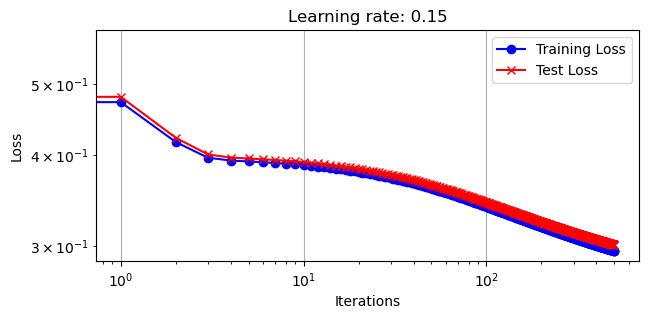

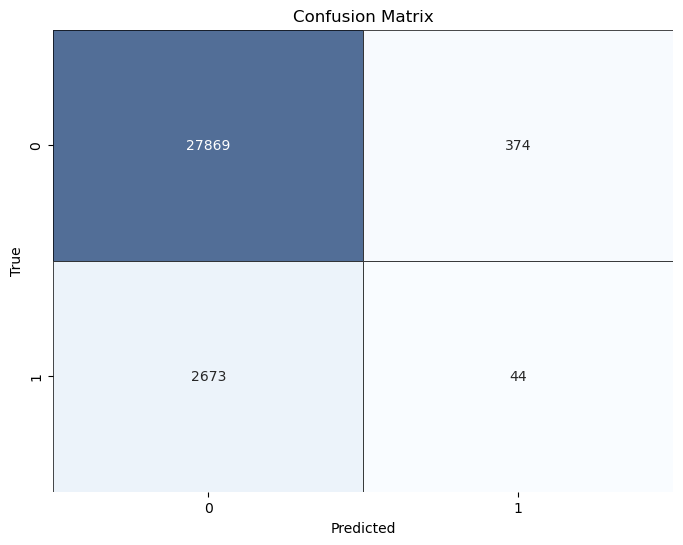

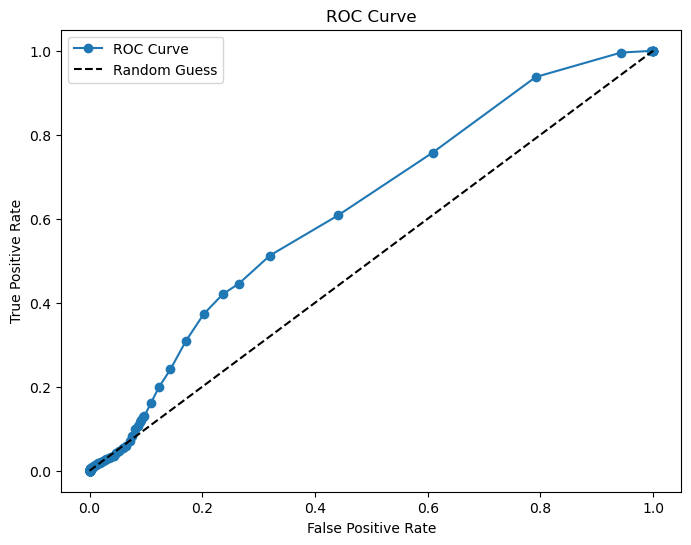

0.028070175438596492


In [49]:
F1_score = one_run_logistic_regression(X_train_transformed_filtered, Y_train_filtered, max_iters=500,  gamma=0.15,reg_norm='', prob_threshold =0.4)
print(F1_score)

**No regularization**

  0%|          | 0/10 [00:00<?, ?it/s]

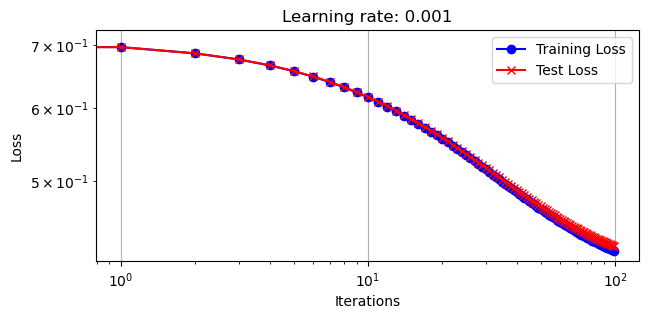

100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


Learning rate = 0.001; Average train loss = 0.4218107588369556; Average test loss: 0.4218142915079498


  0%|          | 0/10 [00:00<?, ?it/s]

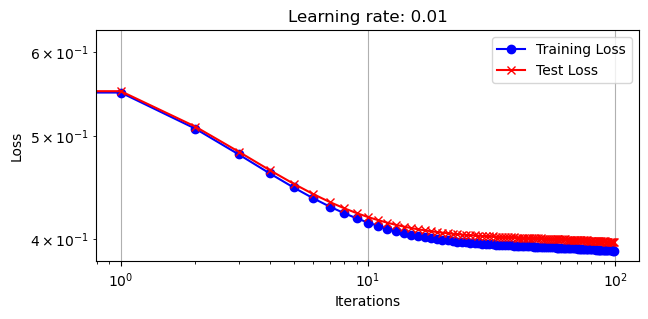

100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


Learning rate = 0.01; Average train loss = 0.3903355049801318; Average test loss: 0.39034915744347976


  0%|          | 0/10 [00:00<?, ?it/s]

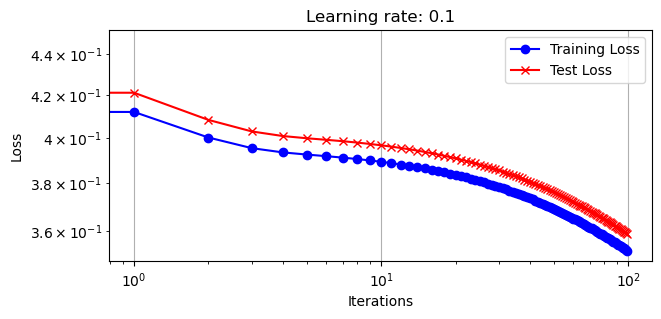

100%|██████████| 10/10 [00:40<00:00,  4.09s/it]

Learning rate = 0.1; Average train loss = 0.3525390421980425; Average test loss: 0.3525551079956691
Best learning rate: 0.1 with test MSE: 0.3525551079956691


(0.1,
 0.3525551079956691,
 {0.1: 0.3525551079956691,
  0.01: 0.39034915744347976,
  0.001: 0.4218142915079498})

In [27]:

# NO REGULARIZATION
k_fold_cross_validation(X_train_transformed_filtered, Y_train_filtered, max_iters=100, gammas=[0.001, 0.01, 0.1], K=10, seed=10,reg_norm='')

**L1 regularization**

  0%|          | 0/10 [00:00<?, ?it/s]

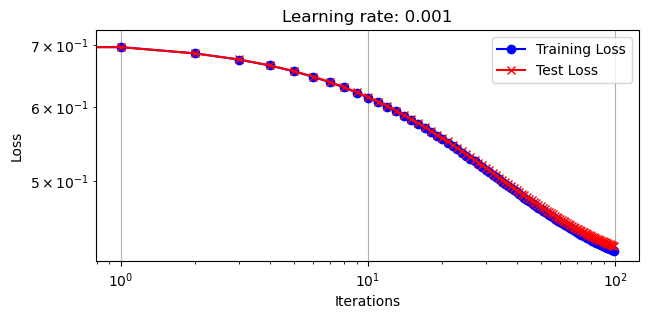

100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


Learning rate = 0.001; Average train loss = 0.42155799425300583; Average test loss: 0.42156152276202974


  0%|          | 0/10 [00:00<?, ?it/s]

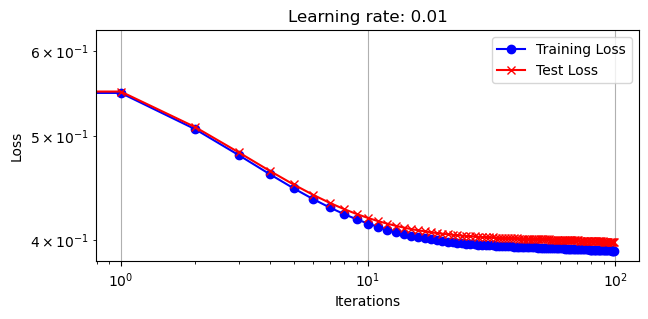

100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


Learning rate = 0.01; Average train loss = 0.39168326133243314; Average test loss: 0.3916965501911872


  0%|          | 0/10 [00:00<?, ?it/s]

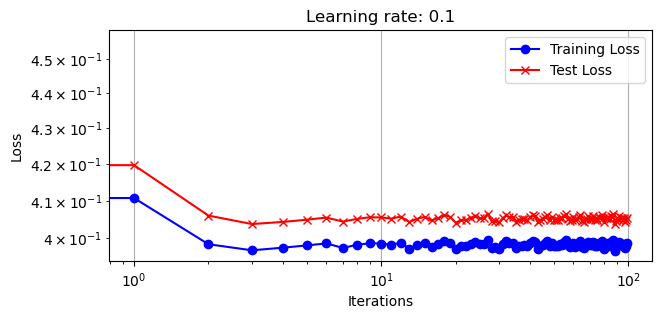

100%|██████████| 10/10 [00:51<00:00,  5.14s/it]

Learning rate = 0.1; Average train loss = 0.39933742811715484; Average test loss: 0.3993514028888126
Best learning rate: 0.01 with test MSE: 0.3916965501911872


(0.01,
 0.3916965501911872,
 {0.01: 0.3916965501911872,
  0.1: 0.3993514028888126,
  0.001: 0.42156152276202974})

In [28]:
k_fold_cross_validation(X_train_transformed, Y_train_filtered, max_iters=100, gammas=[0.001, 0.01, 0.1], K=10, seed=10,reg_norm='l1')

**L2 regularization**

  0%|          | 0/10 [00:00<?, ?it/s]

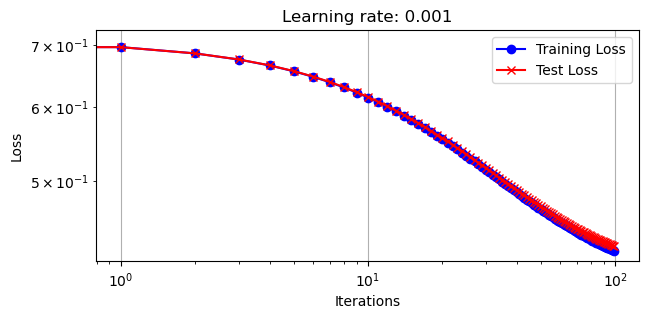

100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


Learning rate = 0.001; Average train loss = 0.4215150776656347; Average test loss: 0.42151860687822784


  0%|          | 0/10 [00:00<?, ?it/s]

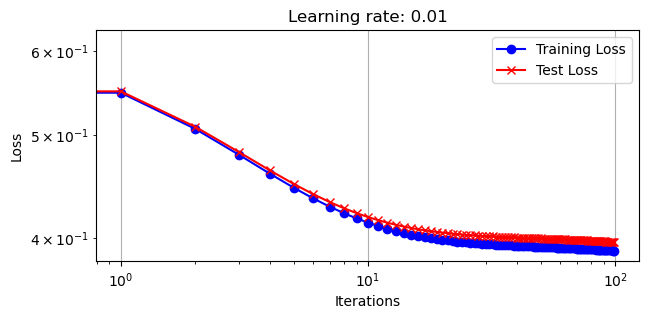

100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Learning rate = 0.01; Average train loss = 0.39032188574570126; Average test loss: 0.39033543467713444


  0%|          | 0/10 [00:00<?, ?it/s]

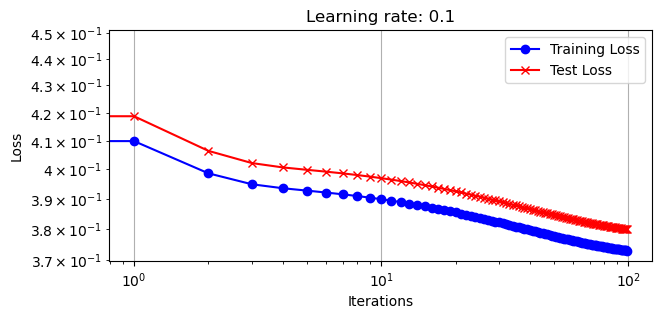

100%|██████████| 10/10 [00:40<00:00,  4.06s/it]

Learning rate = 0.1; Average train loss = 0.37361005148390947; Average test loss: 0.3736236813595209
Best learning rate: 0.1 with test MSE: 0.3736236813595209


(0.1,
 0.3736236813595209,
 {0.1: 0.3736236813595209,
  0.01: 0.39033543467713444,
  0.001: 0.42151860687822784})

In [29]:
k_fold_cross_validation(X_train_transformed, Y_train_filtered, max_iters=100, gammas=[0.001, 0.01, 0.1], K=10, seed=10,reg_norm='l2')

**Incorporating missing values as separate category**

- **Binary**: one column for the actual binary encoding (0 or 1) and a separate column for missing values.

- **Numeric, cont. range**: one column for actual values and separate column for missing values.

- **Categorical**: one column for each category, and an additional column for missing values.

All samples are used (no filtering).

In [33]:
def transform_features_column_for_missing(X, features_dict, original_features):
    """
    Transforms the features in X using one-hot encoding, treating missing values as a separate category.

    Args:
    - X: The input NumPy array (original dataset).
    - features_dict: Dictionary defining feature types and encoding.
    - original_features: List of feature names in the original order of X.

    Returns:
    - X_transformed: NumPy array with transformed features in the specified format.
    """
    transformed_features = []  # List to store transformed feature arrays

    for feature, info in features_dict.items():
        feature_idx = original_features.index(feature)
        feature_values = X[:, feature_idx]

        # Check for missing values and separate them as an additional category
        # Mask for all samples with missing values for feature
        missing_mask = np.isin(feature_values, info['missing_values'])
        
        if info['type'] == 'binary':
            # Binary variable: 1 if "Yes", 0 if "No", and extra column for missing values
            feature_transformed = np.where(feature_values == 1, 1, 0)
            feature_transformed[missing_mask] = 0  # Assign missing values to 0 in binary encoding col
            transformed_features.append(feature_transformed.reshape(-1, 1))
            
            # Add an extra column for missing values
            transformed_features.append(missing_mask.astype(int).reshape(-1, 1))
        
        elif info['type'] == 'categorical':
            # One-hot encode categorical features, adding a column for each category
            categories = info['categories']
            for cat in categories:
                category_mask = (feature_values == cat).astype(int)
                transformed_features.append(category_mask.reshape(-1, 1))
                
            # Add an extra column for missing values
            transformed_features.append(missing_mask.astype(int).reshape(-1, 1))
        
        elif info['type'] == 'numeric':

            # Handle special values (e.g., map 88 as 0 in MENTHLTH)
            if 'map_value' in info:
                special_values = info['map_value']
                for special, replacement in special_values.items():
                    feature_values = np.where(feature_values == special, replacement, feature_values)
            
            # Replace missing values with 0 or other placeholder, if necessary
            feature_transformed = feature_values.astype(float)
            feature_transformed[missing_mask] = 0  # Placeholder for missing numeric values
            transformed_features.append(feature_transformed.reshape(-1, 1))
            
            # Add an extra column for missing values
            transformed_features.append(missing_mask.astype(int).reshape(-1, 1))

    # Concatenate all transformed features to form the final transformed dataset
    X_transformed = np.hstack(transformed_features)
    return X_transformed


X_train_transformed = transform_features_column_for_missing(x_train, features_dict, features)

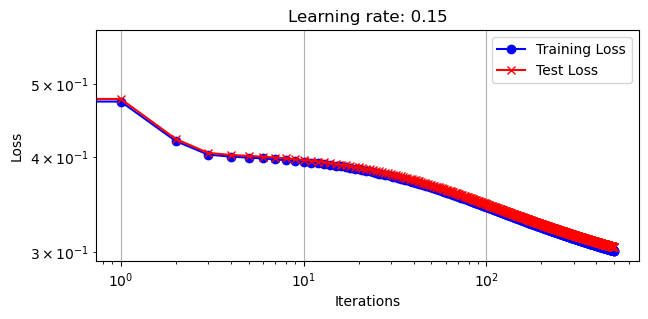

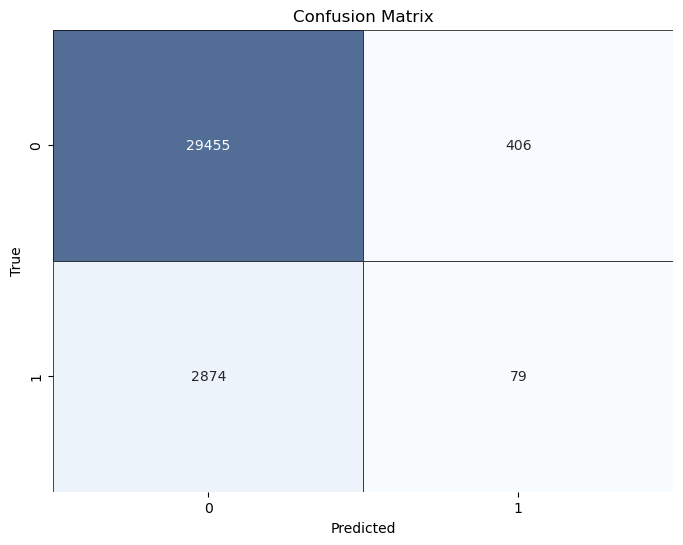

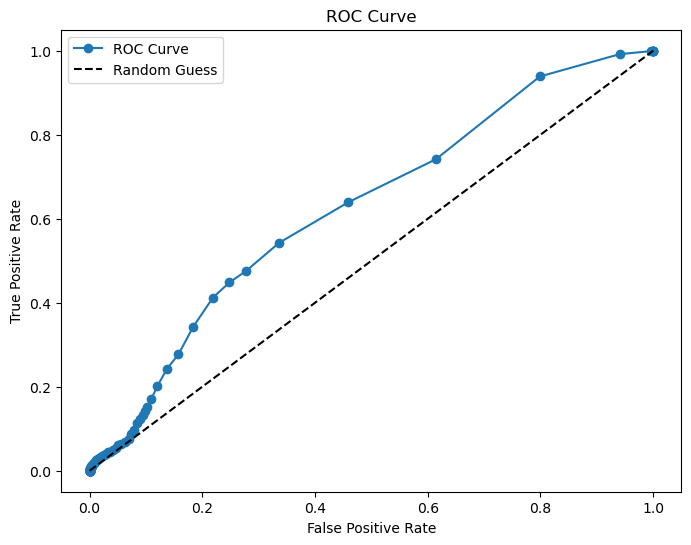

0.04595695171611402


In [51]:

F1_score = one_run_logistic_regression(X_train_transformed, Y_train, max_iters=500,  gamma=0.15,reg_norm='', prob_threshold =0.4)
print(F1_score)

  0%|          | 0/10 [00:00<?, ?it/s]

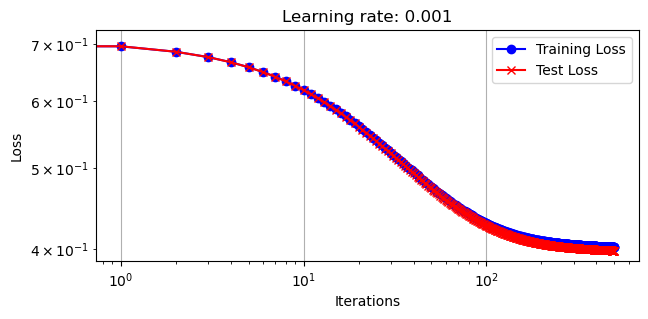

100%|██████████| 10/10 [03:46<00:00, 22.70s/it]


Learning rate = 0.001; Average train loss = 0.4017710767643189; Average test loss: 0.4017766106458566


  0%|          | 0/10 [00:00<?, ?it/s]

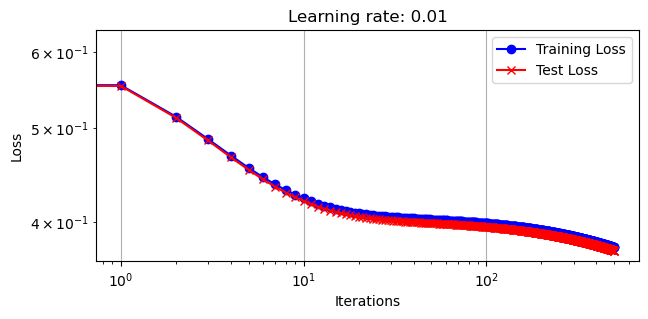

100%|██████████| 10/10 [03:41<00:00, 22.15s/it]


Learning rate = 0.01; Average train loss = 0.3758110445065233; Average test loss: 0.3758189026740944


  0%|          | 0/10 [00:00<?, ?it/s]

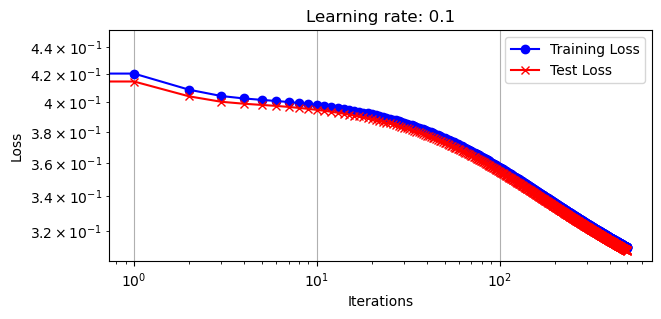

100%|██████████| 10/10 [03:38<00:00, 21.85s/it]

Learning rate = 0.1; Average train loss = 0.310993375137665; Average test loss: 0.3110108881123443
Best learning rate: 0.1 with test MSE: 0.3110108881123443


(0.1,
 0.3110108881123443,
 {0.1: 0.3110108881123443,
  0.01: 0.3758189026740944,
  0.001: 0.4017766106458566})

In [35]:
#  NO REGULARIZATION
k_fold_cross_validation(X_train_transformed, Y_train, max_iters=500, gammas=[0.001, 0.01, 0.1], K=10, seed=10,reg_norm='')

  0%|          | 0/10 [00:00<?, ?it/s]

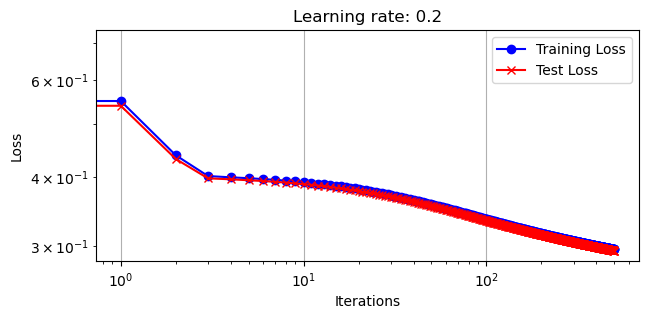

100%|██████████| 10/10 [03:47<00:00, 22.76s/it]


Learning rate = 0.2; Average train loss = 0.2962176578494214; Average test loss: 0.29624119438132723


  0%|          | 0/10 [00:00<?, ?it/s]

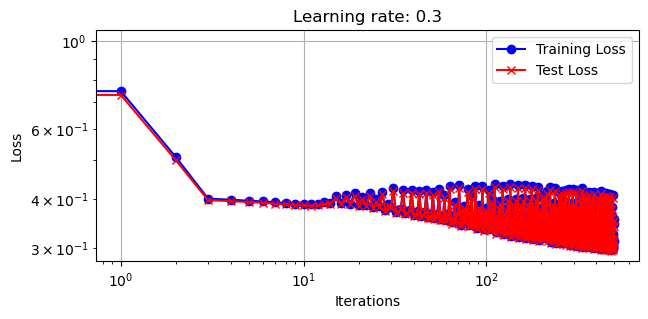

100%|██████████| 10/10 [04:02<00:00, 24.22s/it]


Learning rate = 0.3; Average train loss = 0.3334289567206397; Average test loss: 0.33325189701021646


  0%|          | 0/10 [00:00<?, ?it/s]

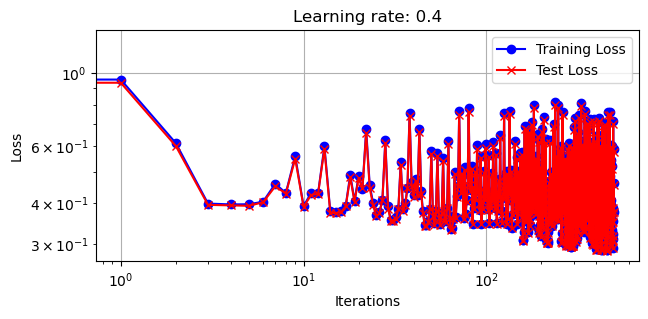

100%|██████████| 10/10 [04:00<00:00, 24.01s/it]

Learning rate = 0.4; Average train loss = 0.5301252059572987; Average test loss: 0.5285472923605526
Best learning rate: 0.2 with test MSE: 0.29624119438132723


(0.2,
 0.29624119438132723,
 {0.2: 0.29624119438132723, 0.3: 0.33325189701021646, 0.4: 0.5285472923605526})

In [36]:
k_fold_cross_validation(X_train_transformed, Y_train, max_iters=500, gammas=[ 0.2, 0.3, 0.4], K=10, seed=10,reg_norm='')

**Rebalancing dataset for training**

  0%|          | 0/10 [00:00<?, ?it/s]

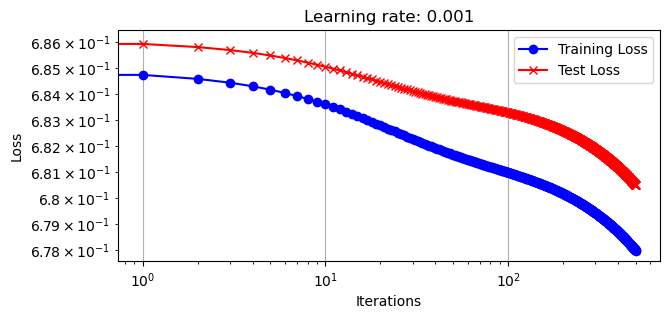

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Learning rate = 0.001; Average train loss = 0.678252973686878; Average test loss: 0.6782776531702035


  0%|          | 0/10 [00:00<?, ?it/s]

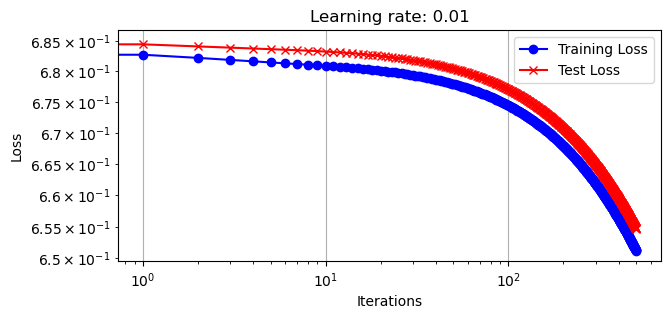

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Learning rate = 0.01; Average train loss = 0.651651544311654; Average test loss: 0.6516977395622188


  0%|          | 0/10 [00:00<?, ?it/s]

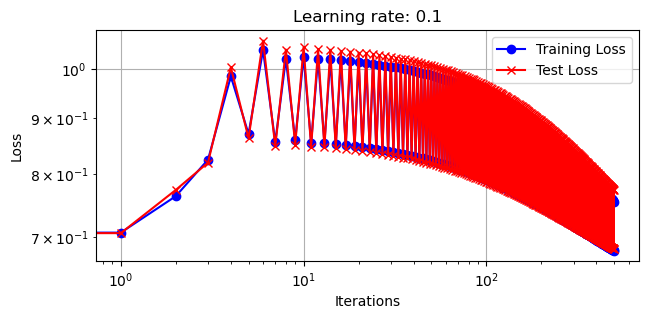

100%|██████████| 10/10 [00:17<00:00,  1.70s/it]

Learning rate = 0.1; Average train loss = 0.6822992727507151; Average test loss: 0.6824850288957206
Best learning rate: 0.01 with test MSE: 0.6516977395622188


(0.01,
 0.6516977395622188,
 {0.01: 0.6516977395622188,
  0.001: 0.6782776531702035,
  0.1: 0.6824850288957206})

In [67]:
# 1. After filtering
X_train_filtered_balanced, Y_train_filtered_balanced = balance_dataset(X_train_filtered, Y_train_filtered)
X_train_filtered_balanced_transformed = transform_features_no_missing(X_train_filtered_balanced, features_dict, features)


k_fold_cross_validation(X_train_filtered_balanced_transformed, Y_train_filtered_balanced, max_iters=500, gammas=[ 0.001, 0.01, 0.1], K=10, seed=10,reg_norm='')
#F1_score = one_run_logistic_regression(X_train_filtered_balanced_transformed, Y_train_filtered_balanced, max_iters=500,  gamma=0.01,reg_norm='', prob_threshold =0.55)
#print(F1_score)

  0%|          | 0/10 [00:00<?, ?it/s]

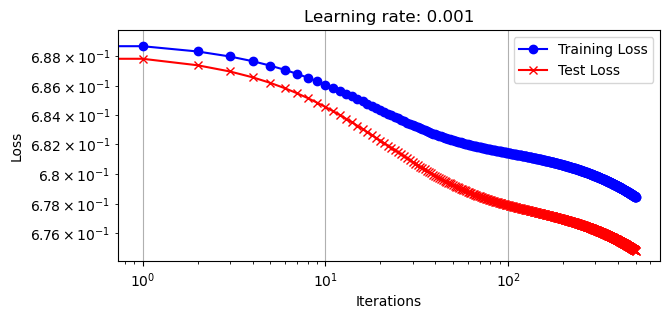

100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Learning rate = 0.001; Average train loss = 0.6780861050752568; Average test loss: 0.6781156313940627


  0%|          | 0/10 [00:00<?, ?it/s]

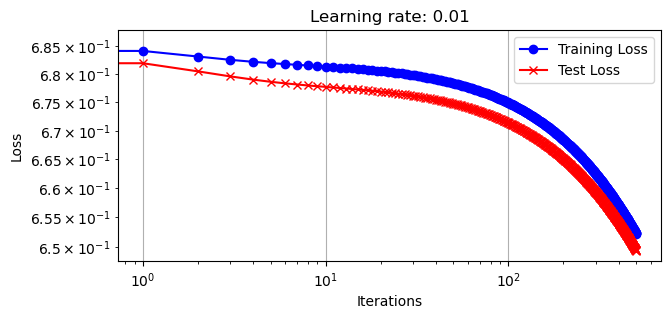

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Learning rate = 0.01; Average train loss = 0.6519920719066872; Average test loss: 0.6520477732749115


  0%|          | 0/10 [00:00<?, ?it/s]

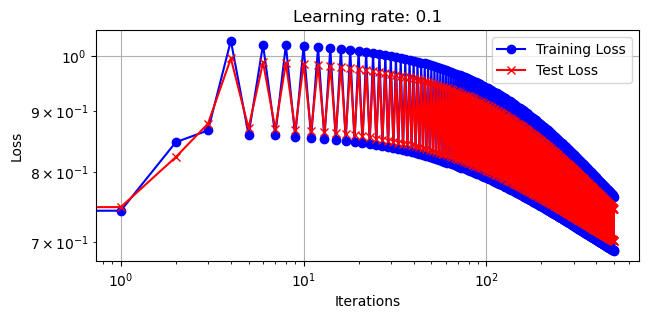

100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

Learning rate = 0.1; Average train loss = 0.686504206758716; Average test loss: 0.6866865563344925
Best learning rate: 0.01 with test MSE: 0.6520477732749115


(0.01,
 0.6520477732749115,
 {0.01: 0.6520477732749115,
  0.001: 0.6781156313940627,
  0.1: 0.6866865563344925})

In [68]:
# 2. No filtering, missing values included
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
X_train_balanced_transformed = transform_features_column_for_missing(X_train_balanced, features_dict, features)

k_fold_cross_validation(X_train_balanced_transformed, Y_train_balanced, max_iters=500, gammas=[ 0.001, 0.01, 0.1], K=10, seed=10,reg_norm='')
#F1_score = one_run_logistic_regression(X_train_balanced_transformed, Y_train_balanced, max_iters=500,  gamma=0.01,reg_norm='', prob_threshold =0.5)

**SGD (variant)**

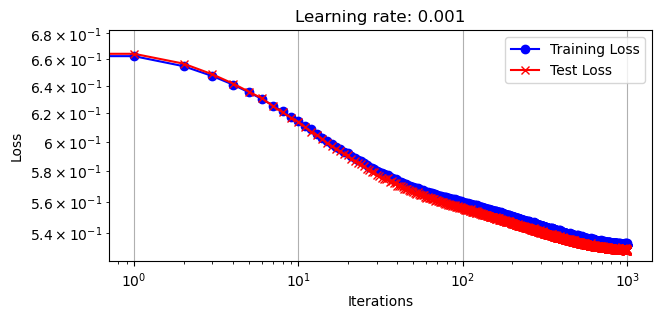

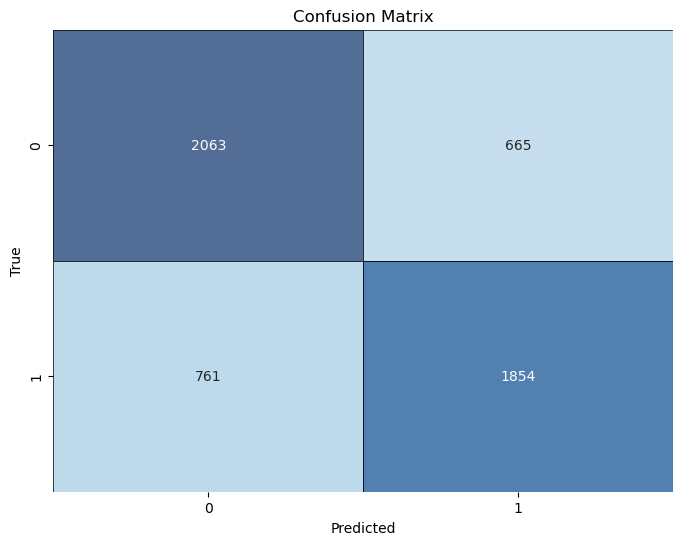

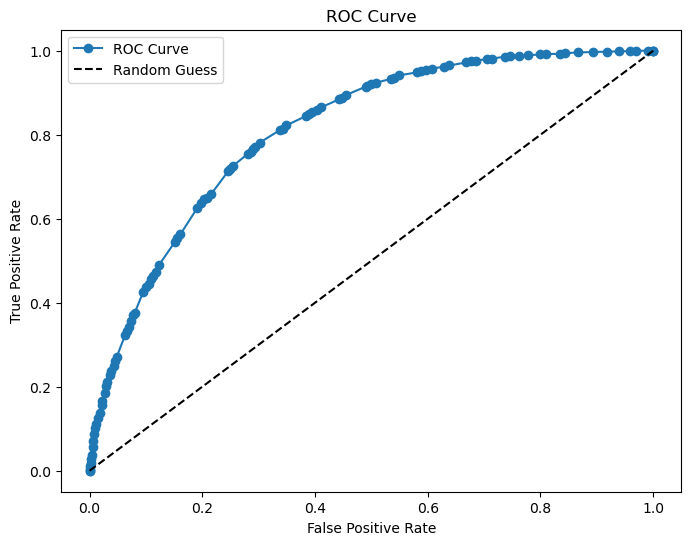

0.7222438644331904


In [91]:
# Filtering 
F1_score = one_run_logistic_regression(X_train_filtered_balanced_transformed, Y_train_filtered_balanced, max_iters=1000,  gamma=0.001,reg_norm='', prob_threshold =0.55, batch_size=32)
print(F1_score)

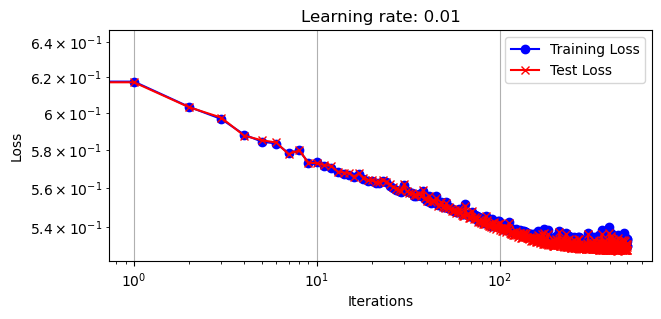

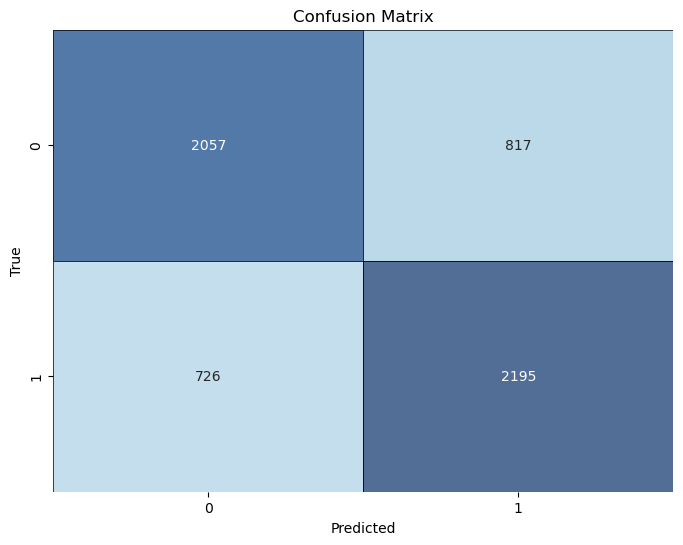

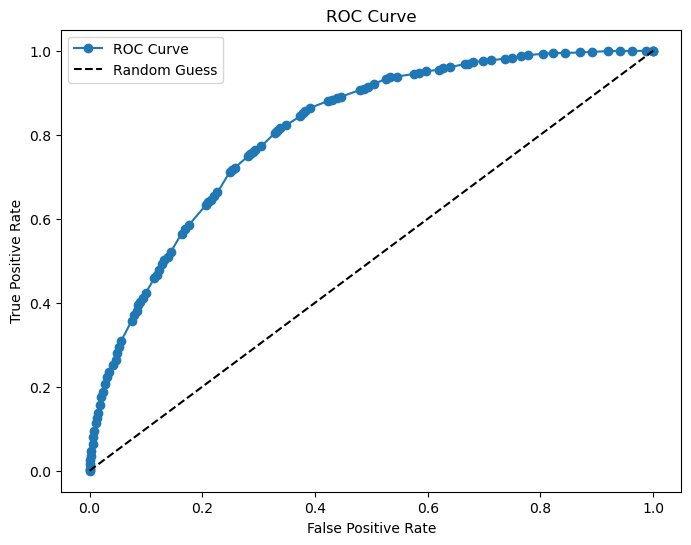

0.739929209506152


In [76]:
# No Filtering

F1_score = one_run_logistic_regression(X_train_balanced_transformed, Y_train_balanced, max_iters=500,  gamma=0.01,reg_norm='', prob_threshold =0.5, batch_size=64)
print(F1_score)

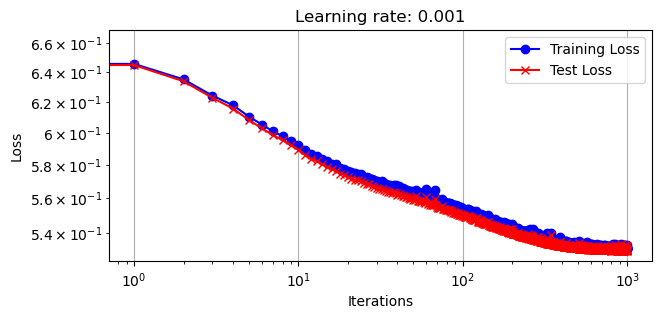

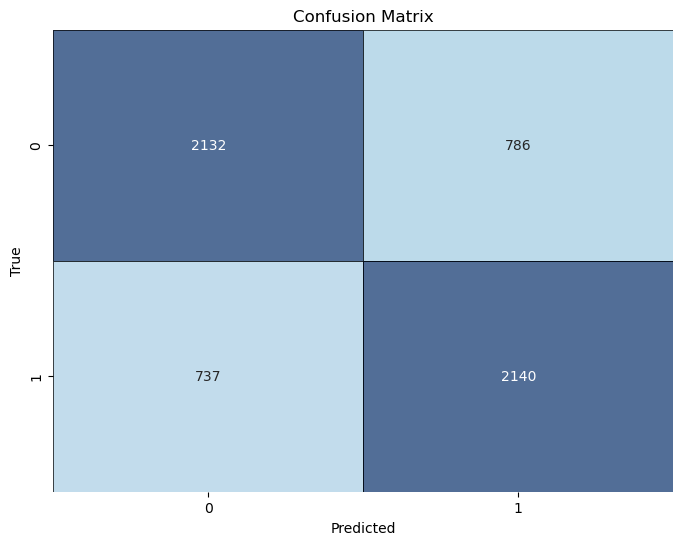

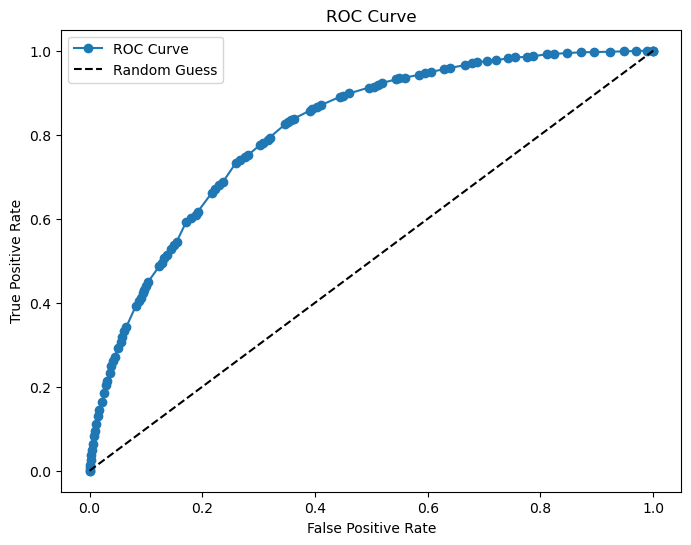

0.737549543339652


In [87]:
F1_score = one_run_logistic_regression(X_train_balanced_transformed, Y_train_balanced, max_iters=1000,  gamma=0.001,reg_norm='', prob_threshold =0.5, batch_size=16)
print(F1_score)

### Trying different features combinations

**Features modification**
- `BPHIGH4`: will be treated as binary ; Yes (1)->1, No(3)->0, Yes during pregnancy (2) -> 0 (No); borderline (4) -> 1 (yes)
- **Consistent scaling**: features (`ALCDAY5`, `STRENGTH`, `EXEROFT1`) with values for 'days per week' and 'days per month' will be standarized so all entries represent 'days per month'.
    - Average number of weeks per month: 4.345
    - 'Days per week' entries: (1)01-(1)99
    - 'Days per month' entries: (2)01-(2)99


**New features**
- `BMI`: from height and weight, a BMI column will be created. First, it is needed to standarize all units:
$$BMI = \frac{weight (lb)*703}{height(in)^2} (kg/m^2)$$ 
    - 
- `'AVG_FRUITS_VEGS'`: Average fruit and vegetable consumption, with: `FRUTDA1_`, `VEGEDA1_`, `GRENDAY_`,
`ORNGDAY_`,`BEANDAY_`

In [ ]:
# Modifying BPHIGH4 column
index_BPHIGH4 = features.index('BPHIGH4')
x_train[:, index_BPHIGH4] = np.where(x_train[:, index_BPHIGH4] == 4, 1, x_train[:, index_BPHIGH4])
x_train[:, index_BPHIGH4] = np.where((x_train[:, index_BPHIGH4] == 2) | (x_train[:, index_BPHIGH4] == 3), 0, x_train[:, index_BPHIGH4])


In [119]:
# Consistent scaling
columns_to_scale = ['ALCDAY5', 'STRENGTH', 'EXEROFT1']
indices = [features.index(col) for col in columns_to_scale]
# Select the columns
selected_columns = x_train[:, indices]

# If value smaller than 200, days per week entry
mask_dw = selected_columns < 200
# Convert to string, remove leading 1, back to float; and scale
selected_columns[mask_dw] = (np.char.lstrip(selected_columns[mask_dw].astype(str), '1').astype(float)) * 4.345 

# If value greater than 200, days per month
mask_dm = selected_columns > 200
# Convert to string, remove leading 1, back to float; and scale
selected_columns[mask_dm] = (np.char.lstrip(selected_columns[mask_dm].astype(str), '2').astype(float)) 

# Update x_train with the transformed columns
x_train[:, indices] = selected_columns

In [105]:

# Creating BMI column
# 1. From kgs to pounds ('WEIGTH2' column)
index_WEIGHT2 = features.index('WEIGHT2')
# Apply to values greater than 9000
mask = x_train[:, index_WEIGHT2] > 8999
# Convert to string, strip the first character if it's '9', then convert back to float
x_train[mask, index_WEIGHT2] = np.char.lstrip(x_train[mask, index_WEIGHT2].astype(str), '9').astype(float)
# Convert from kg to pounds
x_train[mask, index_WEIGHT2] *= 2.20462

# 2. From cm to in ('HEIGHT3' column)
index_HEIGHT3 = features.index('HEIGHT3')

# i. cm -> in
# Apply transformation to values greater than 9000
mask_cm = (x_train[:, index_HEIGHT3] > 8999)
# Convert to string, strip the first character '9', convert back to float, and convert from cm to feet
x_train[mask_cm, index_HEIGHT3] = np.char.lstrip(x_train[mask_cm, index_HEIGHT3].astype(str), '9').astype(float)
x_train[mask_cm, index_HEIGHT3] *= 0.0328084  # Convert from cm to feet

# ii. ftin -> in
mask_ftin = x_train[:, index_HEIGHT3] < 8999
# Ex:  504 -> 5*12 + 4 = 64 inches
x_train[mask_ftin, index_HEIGHT3] = (x_train[mask_ftin, index_HEIGHT3] // 100) * 12 + (x_train[mask_ftin, index_HEIGHT3] % 100)

# Extract the height in inches and weight in pounds for BMI calculation
height_in_inches = x_train[:, index_HEIGHT3] 
weight_in_pounds = x_train[:, index_WEIGHT2] 

# Calculate BMI using the formula
bmi = (weight_in_pounds * 703) / (height_in_inches ** 2)

# Add the BMI column to x_train
x_train = np.column_stack((x_train, bmi))
# Add column name to feature list
features.append('BMI')

In [115]:
# Creating average fruit and vegetable consumption
# Indices of the columns to average
columns_to_average = ['FRUTDA1_', 'VEGEDA1_', 'GRENDAY_', 'ORNGDAY_', 'BEANDAY_']
indices = [features.index(col) for col in columns_to_average]

# Select the columns
selected_columns = x_train[:, indices]

# Calculate the average while ignoring NaN values
# np.nanmean computes the mean ignoring NaN values
# If all values are missing in a row, np.nanmean will return NaN
average_column = np.nanmean(selected_columns, axis=1)


# Add the new average column to x_train
x_train = np.column_stack((x_train, average_column))

# Add the new feature name to the features list
features.append('AVG_FRUITS_VEGS')


C:\Users\beaiz\AppData\Local\Temp\ipykernel_38500\773099227.py:13: RuntimeWarning: Mean of empty slice
  average_column = np.nanmean(selected_columns, axis=1)


In [ ]:
features_dict = {
    # Binary (Yes=1, No=2, Don't know/refuse=7,9)
    'BPMEDS': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'TOLDHI2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIABETE3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'QLACTLM2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'EXERANY2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'SMOKE100': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'HAVARTH3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'SEX': {'type': 'binary', 'missing_values': [np.nan]},
    'BPHIGH4': {'type': 'binary','missing_values': [7, 9, np.nan]},

    # Categorical variable
    '_RACEGR3': {
        'type': 'categorical',
        'missing_values': [9, np.nan],
        'categories': [1, 2, 3, 4, 5]  # White, Black, Other, Multiracial, Hispanic
    },

    # Numeric with map_value for 888, 88
    'SMOKDAY2': {'type': 'numeric', 'missing_values': [7, 9, np.nan], 'range': (1, 3)},
    'ALCDAY5': {'type': 'numeric', 'missing_values': [777, 999, np.nan], 'map_value': {888: 0}, 'range': (1, 99)},
    'AVEDRNK2': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'range': (1, 76)},
    'WEIGHT2': {'type': 'numeric', 'missing_values': [7777, 9999, np.nan], 'range': (50, 999)},
    'HEIGHT3': {'type': 'numeric', 'missing_values': [7777, 9999, np.nan], 'range': (200, 711)},
    'POORHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)},
    'CHECKUP1': {'type': 'numeric', 'missing_values': [7, 9, np.nan], 'map_value':{8:5}, 'range':(1, 5)},
    'STRENGTH': {'type': 'numeric', 'missing_values': [777, 999, np.nan], 'map_value': {888: 0}, 'range': (101, 299)},
    'EXEROFT1': {'type': 'numeric', 'missing_values': [777, 999, np.nan], 'range': (101, 299)},
    'MENTHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)},
    'FRUTDA1_': {'type': 'numeric', 'missing_values': [np.nan], 'range': (0, 9999)},
    'VEGEDA1_': {'type': 'numeric', 'missing_values': [np.nan], 'range': (0, 9999)},
    'GRENDAY_': {'type': 'numeric', 'missing_values': [np.nan], 'range': (0, 9999)},
    'ORNGDAY_': {'type': 'numeric', 'missing_values': [np.nan], 'range': (0, 9999)},
    'BEANDAY_': {'type': 'numeric', 'missing_values': [np.nan], 'range': (0, 9999)},
    'PHYSHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)},
    'JOINPAIN': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'range': (0, 10)},
    '_AGEG5YR': {'type': 'numeric', 'missing_values': [14, np.nan], 'range': (1, 13)}
}